In [1]:

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit import Chem

# Disable warnings from rdkit
from rdkit import rdBase
blocker = rdBase.BlockLogs()

try:
	from tqdm.notebook import tqdm
except ImportError:
	from tqdm import tqdm

from IPython.display import clear_output
from util import save_model
from pickle import load
from time import time

from itables import init_notebook_mode
init_notebook_mode(connected=True, all_interactive=True)

import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

clear_output()

In [2]:
df = pd.read_csv("../data/aqsoldb.csv")
mols = [Chem.MolFromSmiles(s) for s in df["SMILES"].values.tolist()] # Converts SMILES to Mol objects
df.head()

ID                                               Name  \
0  A-3         N,N,N-trimethyloctadecan-1-aminium bromide   
1  A-4                           Benzo[cd]indol-2(1H)-one   
2  A-5                               4-chlorobenzaldehyde   
3  A-8  zinc bis[2-hydroxy-3,5-bis(1-phenylethyl)benzo...   
4  A-9  4-({4-[bis(oxiran-2-ylmethyl)amino]phenyl}meth...   

                                               InChI  \
0  InChI=1S/C21H46N.BrH/c1-5-6-7-8-9-10-11-12-13-...   
1  InChI=1S/C11H7NO/c13-11-8-5-1-3-7-4-2-6-9(12-1...   
2        InChI=1S/C7H5ClO/c8-7-3-1-6(5-9)2-4-7/h1-5H   
3  InChI=1S/2C23H22O3.Zn/c2*1-15(17-9-5-3-6-10-17...   
4  InChI=1S/C25H30N2O4/c1-5-20(26(10-22-14-28-22)...   

                      InChIKey  \
0  SZEMGTQCPRNXEG-UHFFFAOYSA-M   
1  GPYLCFQEKPUWLD-UHFFFAOYSA-N   
2  AVPYQKSLYISFPO-UHFFFAOYSA-N   
3  XTUPUYCJWKHGSW-UHFFFAOYSA-L   
4  FAUAZXVRLVIARB-UHFFFAOYSA-N   

                                              SMILES  Solubility   SD  \
0                [Br-].CCCCCCCCCCCCCCCCCC[N+](C)(C)C   -3.616127  0.0   
1                               O=C1Nc2cccc3cccc1c23   -3.254767  0.0   
2                                    Clc1ccc(C=O)cc1   -2.177078  0.0   
3  [Zn++].CC(c1ccccc1)c2cc(C(C)c3ccccc3)c(O)c(c2)...   -3.924409  0.0   
4  C1OC1CN(CC2CO2)c3ccc(Cc4ccc(cc4)N(CC5CO5)CC6CO...   -4.662065  0.0   

   Ocurrences Group    MolWt  ...  NumRotatableBonds  NumValenceElectrons  \
0           1    G1  392.510  ...               17.0                142.0   
1           1    G1  169.183  ...                0.0                 62.0   
2           1    G1  140.569  ...                1.0                 46.0   
3           1    G1  756.226  ...               10.0                264.0   
4           1    G1  422.525  ...               12.0                164.0   

   NumAromaticRings  NumSaturatedRings  NumAliphaticRings  RingCount    TPSA  \
0               0.0                0.0                0.0        0.0    0.00   
1               2.0                0.0                1.0        3.0   29.10   
2               1.0                0.0                0.0        1.0   17.07   
3               6.0                0.0                0.0        6.0  120.72   
4               2.0                4.0                4.0        6.0   56.60   

    LabuteASA      BalabanJ      BertzCT  
0  158.520601  0.000000e+00   210.377334  
1   75.183563  2.582996e+00   511.229248  
2   58.261134  3.009782e+00   202.661065  
3  323.755434  2.322963e-07  1964.648666  
4  183.183268  1.084427e+00   769.899934  

[5 rows x 26 columns]

# Preliminary data-analysis

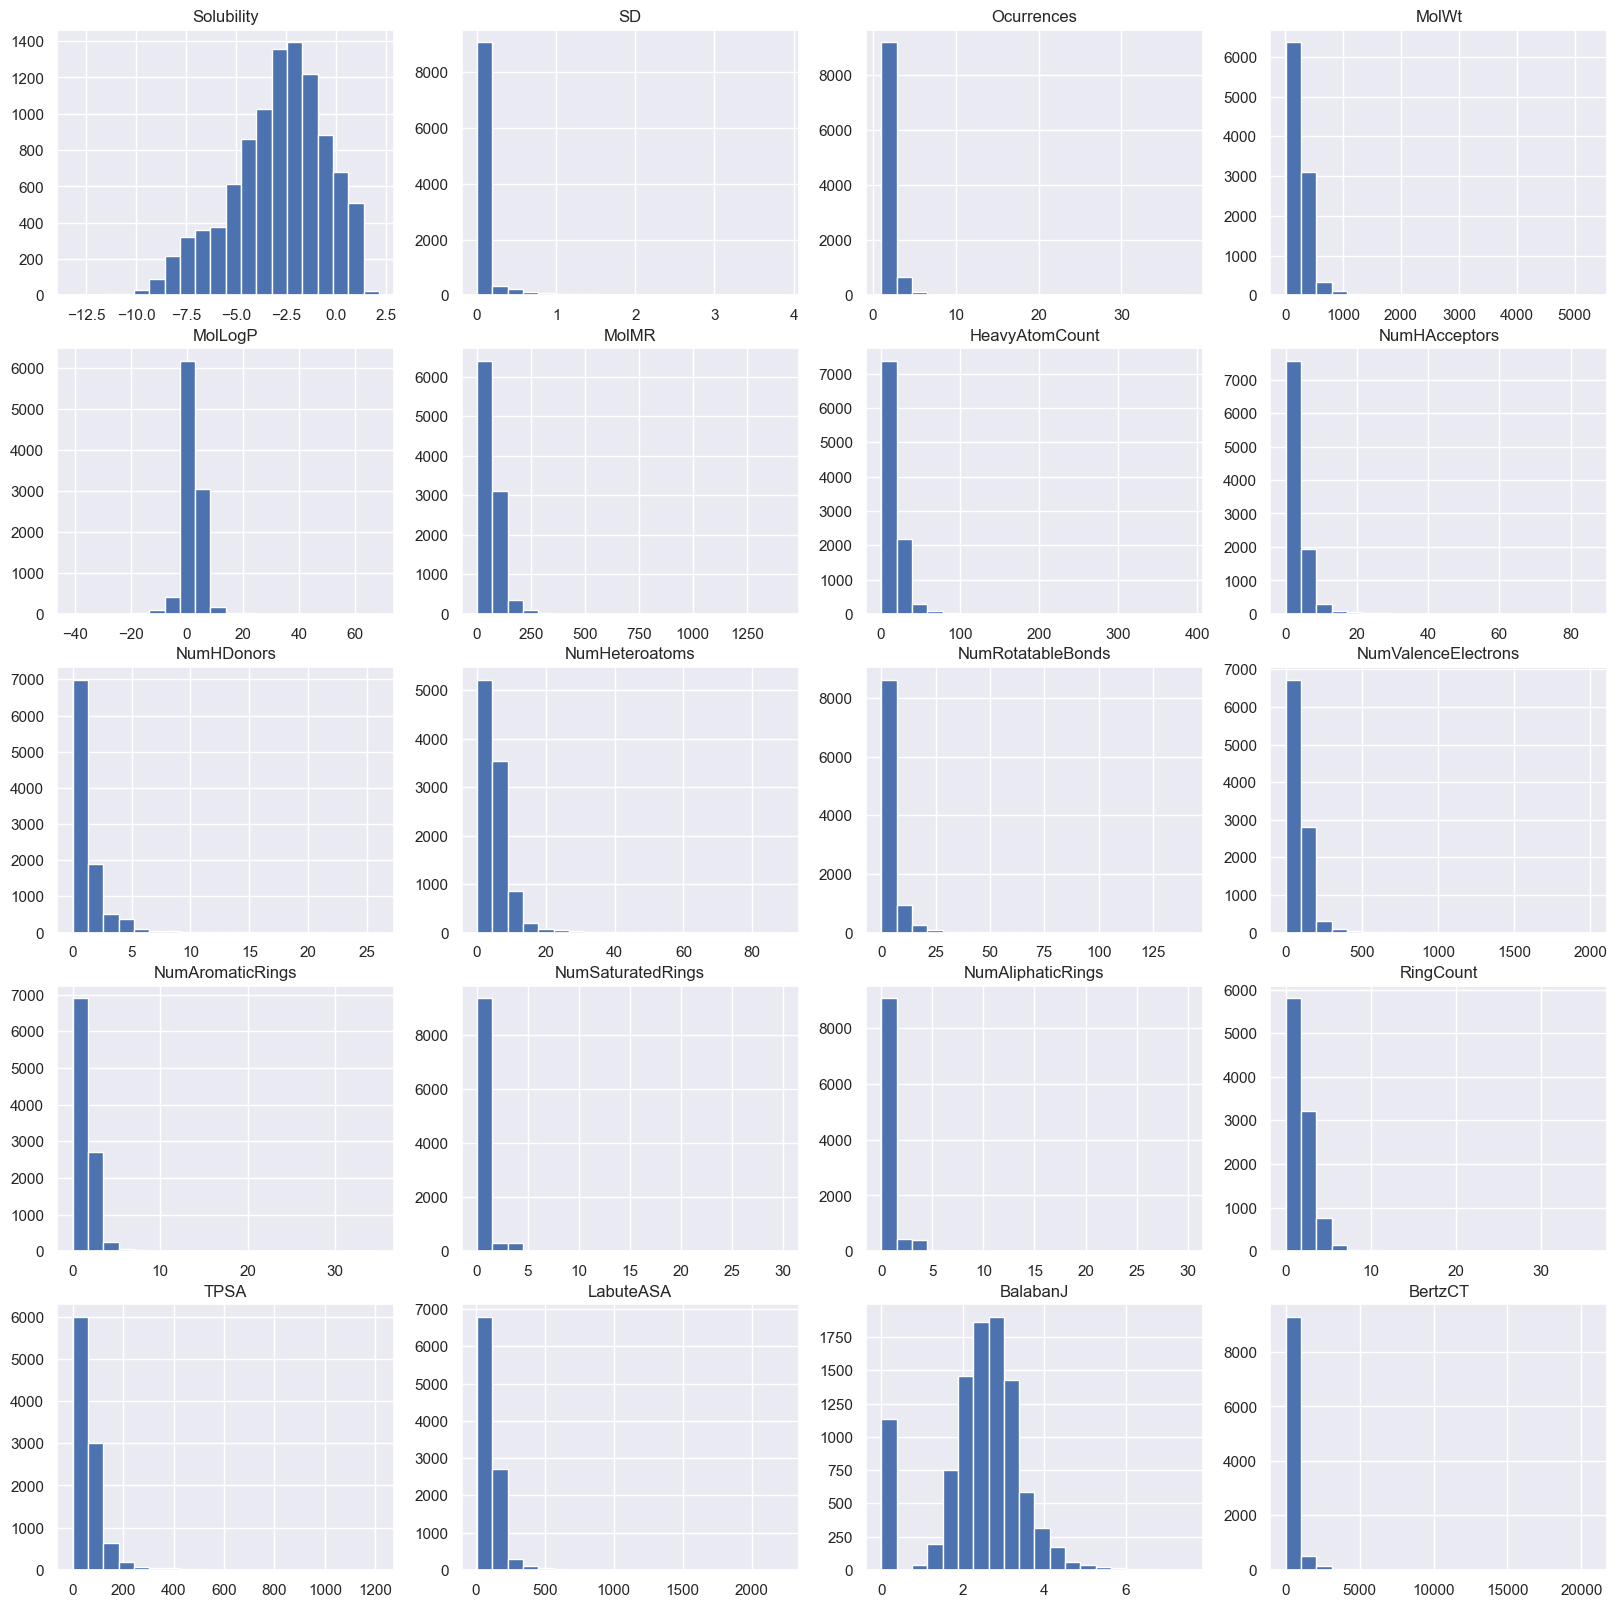

In [86]:
# Histograms of the numeric features

numeric_df = df.select_dtypes(include=[np.number])

pl, ax = plt.subplots(5, 4, figsize=(20, 20))
for i, col in enumerate(numeric_df.columns):
	c = numeric_df[col]
	ax[i // 4, i % 4].hist(c, bins=20)
	ax[i // 4, i % 4].set_title(col)

plt.show()

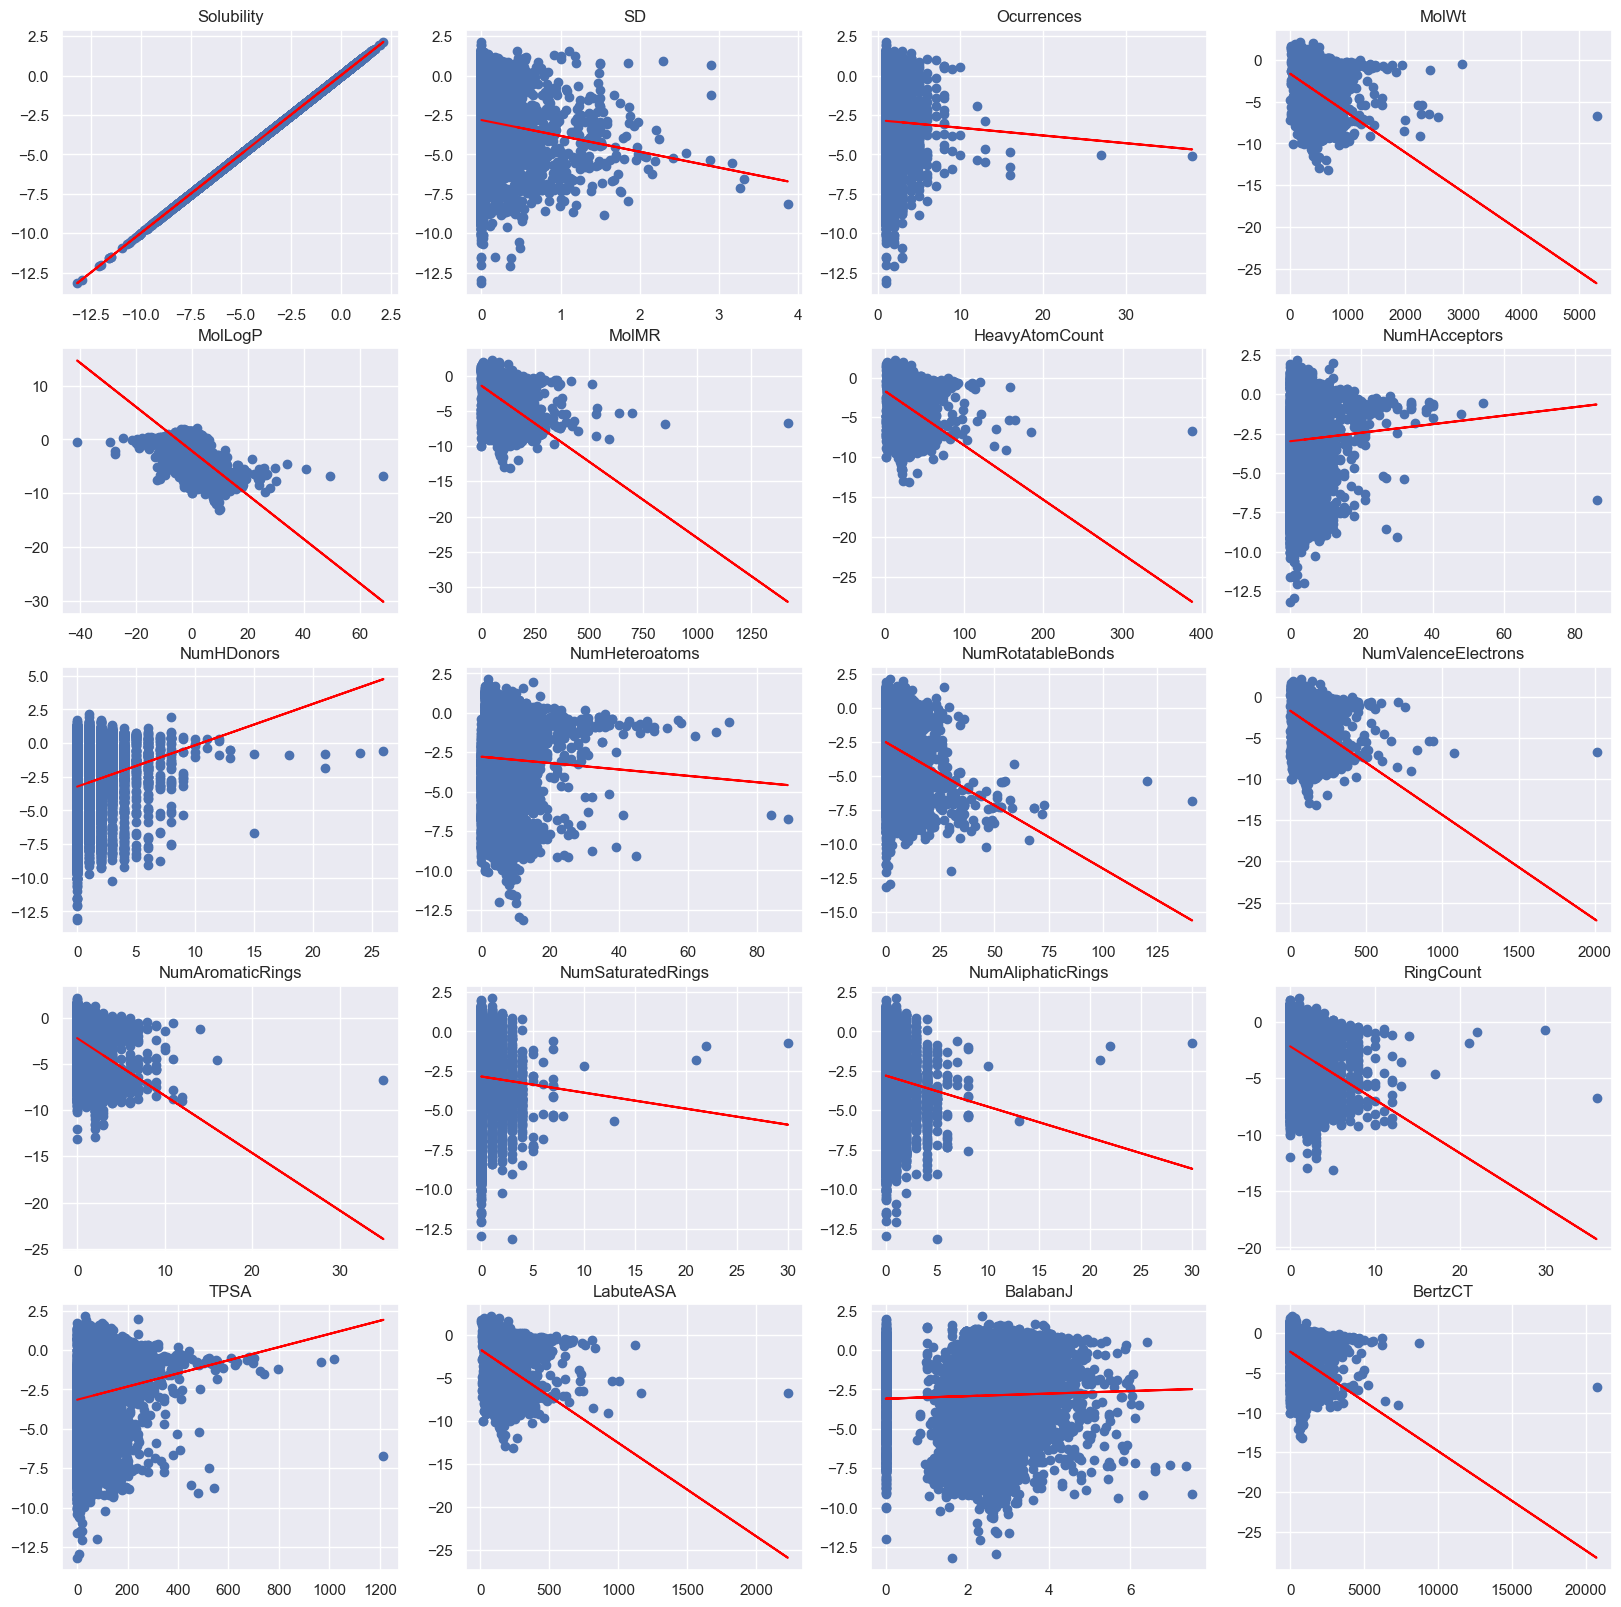

In [89]:
# Scatters of each numeric feature against solubility

pl, ax = plt.subplots(5, 4, figsize=(20, 20))
for i, col in enumerate(numeric_df.columns):
	lm = LinearRegression()
	lm.fit(numeric_df[col].values.reshape(-1, 1), df["Solubility"])
	ax[i // 4, i % 4].scatter(numeric_df[col], df["Solubility"])
	ax[i // 4, i % 4].plot(numeric_df[col], lm.predict(numeric_df[col].values.reshape(-1, 1)), color="red")
	ax[i // 4, i % 4].set_title(col)

plt.show()

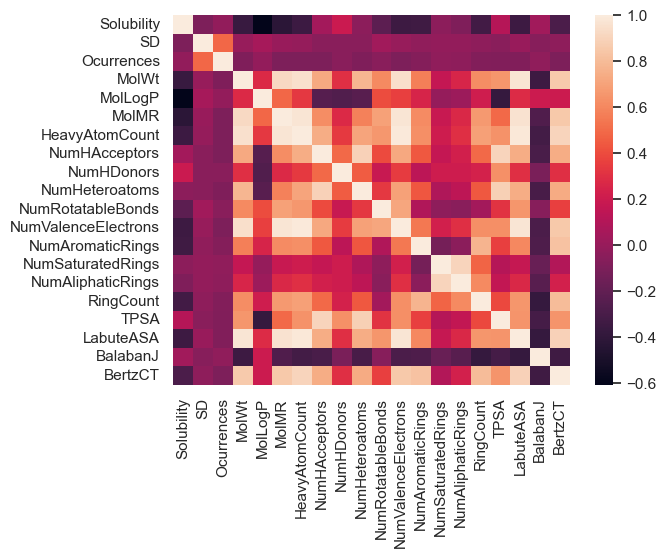

In [5]:
# Correlation matrix

sns.heatmap(df.corr(numeric_only=True))
plt.show()

Max: 400 bonds, 388 atoms
Min: 0 bonds, 1 atoms
Mean: 17.63 bonds, 17.38 atoms
Median: 15.00 bonds, 15.00 atoms

Number of molecules with more than 100 atoms: 18
Number of molecules with more than 100 bonds: 19


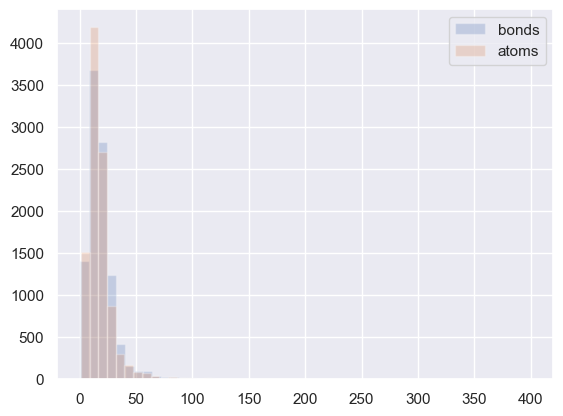

In [23]:
# Histogram of # of bonds and # of atoms

bonds = [m.GetNumBonds() for m in mols]
plt.hist(bonds, bins=50, alpha=0.25, label="bonds")

atoms = [m.GetNumAtoms() for m in mols]
plt.hist(atoms, bins=50, alpha=0.25, label="atoms")

print(f"""Max: {max(bonds)} bonds, {max(atoms)} atoms
Min: {min(bonds)} bonds, {min(atoms)} atoms
Mean: {np.mean(bonds):.2f} bonds, {np.mean(atoms):.2f} atoms
Median: {np.median(bonds):.2f} bonds, {np.median(atoms):.2f} atoms""")

print()
mols_more_100_atoms = sum([1 for a in atoms if a > 100])
mols_more_100_bonds = sum([1 for b in bonds if b > 100])
print(f"Number of molecules with more than 100 atoms: {mols_more_100_atoms}")
print(f"Number of molecules with more than 100 bonds: {mols_more_100_bonds}")

plt.legend()
plt.show()

# Featurizing molecules

In [3]:
# Custom descriptor featurizer

descriptors = load(open("./descriptors.pkl", "rb"))
descriptor = MolecularDescriptorCalculator(descriptors)

start = time()
feats = np.zeros((len(mols), len(descriptors)))
for i, mol in enumerate(tqdm(mols)):
    feats[i, :] = descriptor.CalcDescriptors(mol)

## Results saved to ./descriptors.pkl
# descriptors = [x[0] for x in Chem.Descriptors.descList]
# removals = ["MinPartialCharge", "MinAbsPartialCharge", "MaxPartialCharge", "MaxAbsPartialCharge", "BCUT2D_MWHI", "BCUT2D_MWLOW", "BCUT2D_CHGHI", "BCUT2D_CHGLO", "BCUT2D_LOGPHI", "BCUT2D_LOGPLOW", "BCUT2D_MRHI", "BCUT2D_MRLOW", "Ipc"]
# descriptors = [d for d in descriptors if d not in removals]

  0%|          | 0/9982 [00:00<?, ?it/s]

In [22]:
# fr_ descriptors

frs = [(i, x) for (i, x) in enumerate(descriptors) if x.startswith("fr_")]
fr_df = pd.DataFrame(index=[f[1] for f in frs], columns=["values", "max", "min", "avg", "med", "uniques", "non-zero"])
fr_df["values"] = [[] for _ in range(len(fr_df))]

for mol_feats in tqdm(feats):
	for (feat_index, name) in frs:
		value = mol_feats[feat_index]
		fr_df.loc[name, "values"].append(value)

fr_df["max"] = [max(x) for x in fr_df["values"]]
fr_df["min"] = [min(x) for x in fr_df["values"]]
fr_df["avg"] = [np.mean(x) for x in fr_df["values"]]
fr_df["med"] = [np.median(x) for x in fr_df["values"]]
fr_df["uniques"] = [len(set(x)) for x in fr_df["values"]]
fr_df["non-zero"] = [len([x for x in values if x != 0]) for values in fr_df["values"]]
fr_df.drop(columns=["values"], inplace=True)

clear_output()

fr_df

max  min       avg  med  uniques  non-zero
fr_Al_COO           7.0  0.0  0.136145  0.0        8       979
fr_Al_OH           24.0  0.0  0.259868  0.0       17      1416
fr_Al_OH_noTert    24.0  0.0  0.229313  0.0       17      1244
fr_ArN              5.0  0.0  0.073031  0.0        6       599
fr_Ar_COO           4.0  0.0  0.046283  0.0        5       383
...                 ...  ...       ...  ...      ...       ...
fr_thiazole         2.0  0.0  0.008215  0.0        3        78
fr_thiocyan         3.0  0.0  0.001102  0.0        3         9
fr_thiophene        1.0  0.0  0.006712  0.0        2        67
fr_unbrch_alkane  114.0  0.0  0.785314  0.0       45      1283
fr_urea             4.0  0.0  0.039471  0.0        4       366

[85 rows x 6 columns]

In [13]:
# Nan/inf checker

maxFloat = np.finfo("float32").max

xs = []
for y, mol_feats in enumerate(tqdm(feats)):
	for x, f in enumerate(mol_feats):
		if np.isnan(f) or np.isinf(f) or f > maxFloat or f < -maxFloat:
			xs.append(x)

clear_output()

nans = [f"{descriptors[i]} ({i})" for i in set(xs)]
if len(nans) == 0:
    print("No nans/infs found")
else:
    print(nans)

No nans/infs found


Top 10 correlations
MolLogP (109)            0.608801
PEOE_VSA6 (43)           0.507025
FpDensityMorgan1 (10)    0.497795
MolMR (110)              0.424335
Chi3v (25)               0.397288
Chi3n (24)               0.394366
VSA_EState10 (82)        0.392012
Chi2n (22)               0.391945
SlogP_VSA7 (66)          0.388096
Chi1n (20)               0.387503
Name: Solubility, dtype: float64


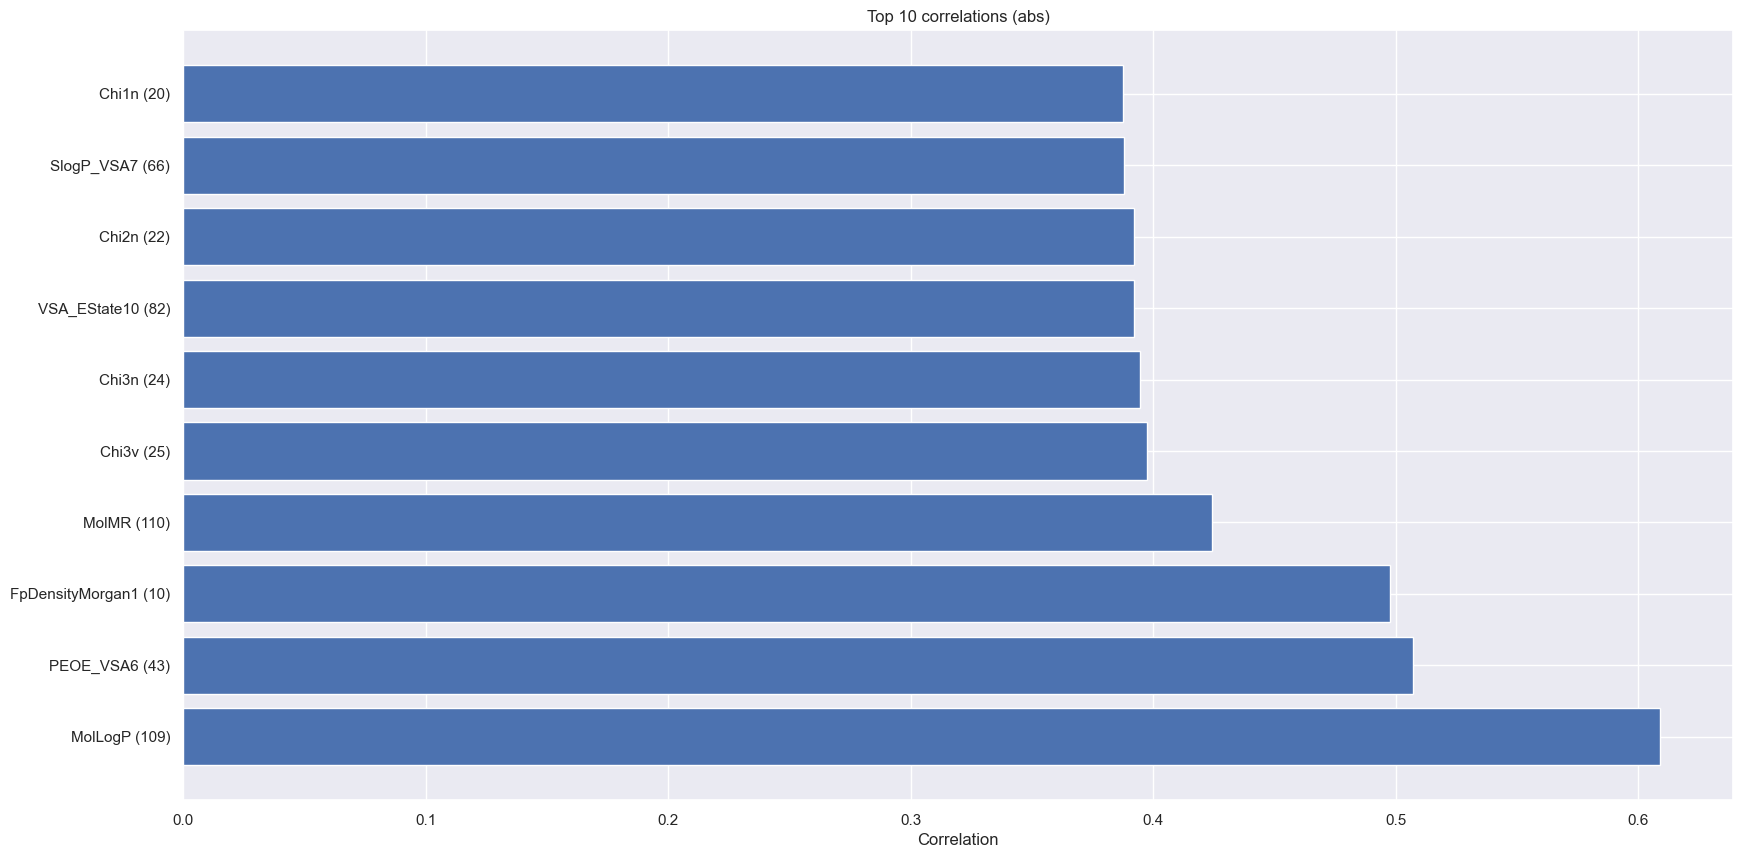

In [108]:
# Correlations of each feature with solubility
new_df = pd.DataFrame(feats, columns=[f"feat_{i}" for i in range(feats.shape[1])])
new_df["Solubility"] = df["Solubility"]

def map_index(i):
	i = int(i.replace("feat_", ""))
	return f"{descriptors[i]} ({i})"

corr: pd.Series = new_df.corr()["Solubility"].abs().sort_values(ascending=False).drop("Solubility")
corr.index = [map_index(i) for i in corr.index]

top_corrs = corr.head(10)

print("Top 10 correlations")
print(top_corrs)

plt.figure(figsize=(20, 10))
plt.barh(top_corrs.index, top_corrs.values)
plt.xlabel("Correlation")
plt.title("Top 10 correlations (abs)")
plt.show()

# Models

### Results (Time includes cross-validation) (Sorted by mean 5-fold RMSE)

| Model | Time | Mean 5-fold RMSE | Mean 5-fold r^2 | RMSE | r^2 |
| --- | --- | --- | --- | --- | --- |
| Random forest | 23.2s | 1.1444 | 0.7599 | 1.1474 | 0.7683 |
| Bagging (Random forest estimator) | 1m 14.2s | 1.1461 | 0.760 | 1.1529 | 0.7660 |
| Bagging (Decision tree estimator) | 21.6s | 1.1466 | 0.7563 | 1.1565 | 0.7646 |
| Gradient boosting | 12.7s | 1.1767 | 0.7443 | 1.2129 | 0.7411 |
| Random forest (top 10 features) | 2.6s | 1.1775 | 0.7410 | 1.2198 | 0.7381 |
| Decision tree | 3.1s | 1.3269 | 0.6747 | 1.3840 | 0.6629 |
| AdaBoost | 7.2s | 1.4032 | 0.6358 | 1.4327 | 0.6387 |

In [20]:
# Framework for testing models

features = feats
labels = df["Solubility"]

## Top 10 features
# top_features = ["MolLogP", "BertzCT", "MolMR", "BalabanJ", "HallKierAlpha", "HeavyAtomMolWt", "VSA_EState10", "qed", "FractionCSP3", "SMR_VSA10"]
# top_features_indicies = [descriptors.index(f) for f in top_features]

# features = feats[:, top_features_indicies]

x_test, x_train, y_test, y_train = train_test_split(features, labels, test_size=0.3, random_state=42)

def test_model(model, score_and_print=True):
    if score_and_print:
        metric = make_scorer(mean_squared_error, squared=False)
        cross_score = cross_val_score(estimator=model, X=x_train, scoring=metric, y=y_train, cv=5, n_jobs=-1)
        print(f"Mean 5-fold RMSE: {cross_score.mean():.4f}")

        metric = make_scorer(r2_score)
        cross_score = cross_val_score(estimator=model, X=x_train, scoring=metric, y=y_train, cv=5, n_jobs=-1)
        print(f"Mean 5-fold r^2:  {cross_score.mean():.4f}")

    model.fit(x_train, y_train)

    if score_and_print:
        preds = model.predict(x_test)
        rmse = mean_squared_error(y_test, preds, squared=False)
        print(f"Test RMSE:        {rmse:.4f}")

        r2 = r2_score(y_test, preds)
        print(f"R2:               {r2:.4f}")

    return (cross_score, rmse, model) if score_and_print else model

def print_importances(feature_importances):
    importance_df = pd.DataFrame({ "descriptor": descriptors, "importance": feature_importances }).sort_values("importance", ascending=False)
    sns.barplot(x="importance", y="descriptor", data=importance_df.head(10))

def draw_tree(tree):
    plt.figure(figsize=(20, 10))
    plot_tree(tree, filled=True, feature_names=descriptors, fontsize=10)
    plt.show()

In [21]:
# Random forest

_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", RandomForestRegressor(n_estimators=50, n_jobs=-1, max_depth=19))
]))

print()
print_importances(model.named_steps["estimator"].feature_importances_)

save_model(model, "random_forest")

Mean 5-fold RMSE: 1.1909
Mean 5-fold r^2:  0.7386
Test RMSE:        1.2173
R2:               0.7392



In [17]:
# Decision tree
_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", DecisionTreeRegressor(max_depth=7, min_samples_split=7, min_samples_leaf=11))
]))

print()
print_importances(model.named_steps["estimator"].feature_importances_)

save_model(model, "decision_tree")

Mean 5-fold RMSE: 1.2996
Mean 5-fold r^2:  0.6886
Test RMSE:        1.3445
R2:               0.6818



ValueError: All arrays must be of the same length

Mean 5-fold RMSE: 1.1767
Mean 5-fold r^2:  0.7443
Test RMSE:        1.2129
Score:            0.8054
R2:               0.7411



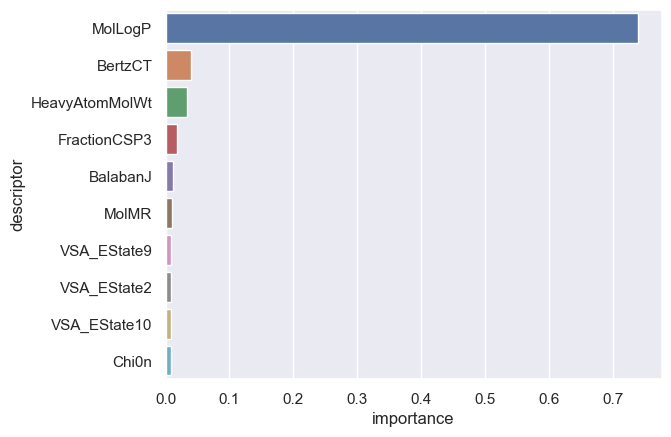

In [81]:
# Gradient boosting

_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", GradientBoostingRegressor(n_estimators=50))
]))

print()
print_importances(model.named_steps["estimator"].feature_importances_)

save_model(model, "gradient_boosting")

Mean 5-fold RMSE: 1.4032
Mean 5-fold r^2:  0.6358
Test RMSE:        1.4327
Score:            0.6899
R2:               0.6387



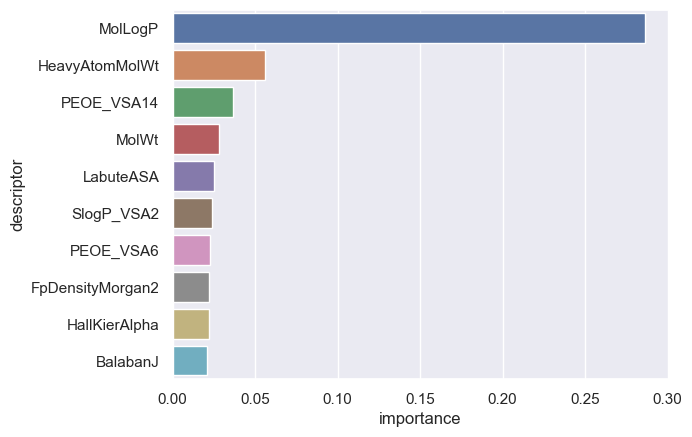

In [82]:
# AdaBoost

_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", AdaBoostRegressor(n_estimators=50))
]))

print()
print_importances(model.named_steps["estimator"].feature_importances_)

save_model(model, "adaboost")

Mean 5-fold RMSE: 1.1461
Mean 5-fold r^2:  0.7605
Test RMSE:        1.1529
Score:            0.9145
R2:               0.7660



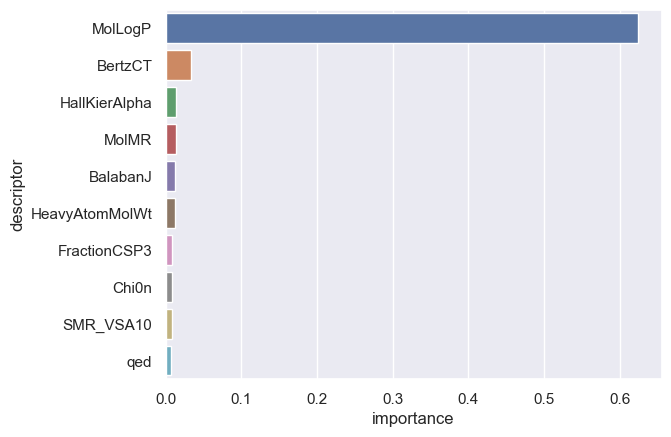

In [6]:
# Bagging

_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", BaggingRegressor(n_estimators=20, n_jobs=-1, estimator=RandomForestRegressor(n_estimators=15, n_jobs=-1, max_depth=19)))
]))


feature_importances = np.mean([
    tree.feature_importances_ for tree in model.named_steps["estimator"].estimators_
], axis=0)

print()
print_importances(feature_importances)

save_model(model, "bagging")

Mean 5-fold RMSE: 1.1466
Mean 5-fold r^2:  0.7563
Test RMSE:        1.1565
Score:            0.9659
R2:               0.7646



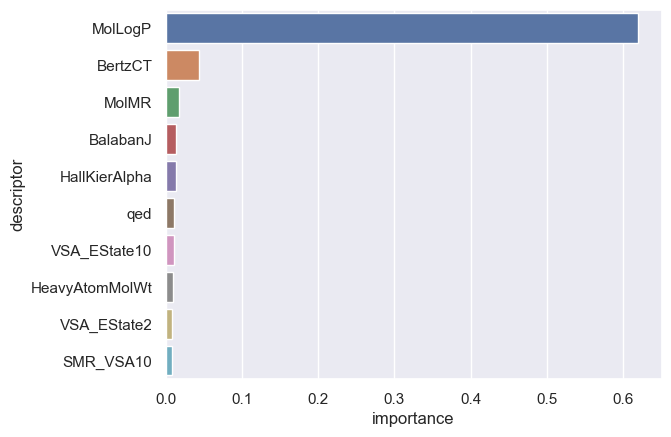

In [12]:
# Bagging reg

_, _, model = test_model(Pipeline(steps=[
    ("scaler", RobustScaler()),
    ("estimator", BaggingRegressor(n_estimators=50, n_jobs=-1))
]))


feature_importances = np.mean([
    tree.feature_importances_ for tree in model.named_steps["estimator"].estimators_
], axis=0)

print()
print_importances(feature_importances)

save_model(model, "bagging_reg")

# Hyperparameter tuning

### Random forest

- Max depth : `19`

### Decision tree

- Max depth : `7`
- Min samples leaf : `11`
- Min samples split : `7`

In [63]:
# Random forest hyperparamater tuning

params = {
	"max_depth": list(range(15, 25, 1)),
	# "min_samples_split": [6, 7, 8, 9],
	# "min_samples_leaf": [10, 11, 12, 13],
}

cv = GridSearchCV(RandomForestRegressor(n_estimators=50, n_jobs=-1), params, n_jobs=-1, verbose=10, scoring=["neg_root_mean_squared_error", "r2"], refit="neg_root_mean_squared_error")
cv.fit(x_train, y_train)
cv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'max_depth': 19}

In [54]:
# Decision tree hyperparameter tuning

params = {
	"max_depth": [6, 7, 8],
	"min_samples_split": [6, 7, 8, 9],
	"min_samples_leaf": [10, 11, 12, 13],
}

cv = GridSearchCV(DecisionTreeRegressor(), params, n_jobs=-1, verbose=10, scoring=["neg_root_mean_squared_error", "r2"], refit="neg_root_mean_squared_error")
cv.fit(x_train, y_train)
cv.best_params_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'max_depth': 7, 'min_samples_leaf': 11, 'min_samples_split': 7}